In [1]:
import io
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import  train_test_split
# sklearn provides CountVectorizer that converts a   collection of text documents to a matrix of token counts while   TfidfVectorizer converts a collection of raw documents to a matrix of TF-IDF   features.
from sklearn.feature_extraction.text import CountVectorizer,   TfidfVectorizer
from sklearn.metrics import  mean_squared_error as mse, r2_score
from sklearn.model_selection import  KFold, StratifiedKFold
from sklearn.linear_model import  LogisticRegression

# Simpletransformers provides a simple way of training   transformers on NLP tasks
from simpletransformers.classification import  ClassificationModel
import warnings
warnings.filterwarnings("ignore")

In [2]:
train_df = pd.read_csv('/home/karen/Documents/Datasets/Vaccination_sentiments/Train.csv')
test_df = pd.read_csv('/home/karen/Documents/Datasets/Vaccination_sentiments/Test.csv')

In [3]:
train_df

,tweet_id,safe_text,label,agreement
0,CL1KWCMY,Me &amp; The Big Homie meanboy3000 #MEANBOY #M...,0.0,1.000000
1,E3303EME,I'm 100% thinking of devoting my career to pro...,1.0,1.000000
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE Y...",-1.0,1.000000
3,1DR6ROZ4,I mean if they immunize my kid with something ...,-1.0,1.000000
4,J77ENIIE,Thanks to <user> Catch me performing at La Nui...,0.0,1.000000
...,...,...,...,...
9996,IU0TIJDI,Living in a time where the sperm I used to was...,1.0,1.000000
9997,WKKPCJY6,<user> <user> In spite of all measles outbrea...,1.0,0.666667
9998,ST3A265H,Interesting trends in child immunization in Ok...,0.0,1.000000
9999,6Z27IJGD,CDC Says Measles Are At Highest Levels In Deca...,0.0,1.000000


In [4]:
train_df.isnull().sum()

tweet_id     0
safe_text    0
label        1
agreement    2
dtype: int64

In [5]:
train_df = train_df.dropna()

In [6]:
train_df.isnull().sum()

tweet_id     0
safe_text    0
label        0
agreement    0
dtype: int64

In [7]:
train_df.label.value_counts()

 0.0    4908
 1.0    4053
-1.0    1038
Name: label, dtype: int64

<Axes: xlabel='label', ylabel='count'>

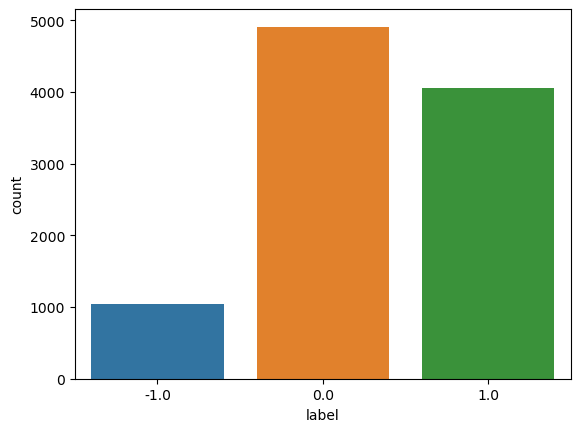

In [8]:
import seaborn as sns
sns.countplot(x=train_df['label'])

In [9]:
def clean_text(text):
    # Remove <user>   tags
    test = str(text)
    text = re.sub(r'<.*?>', '',   text)
    # Replace &amp; with   'and'
    text = re.sub(r"&amp;", "and",   text) 
    # Replace punctuation   characters with spaces
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
    translate_dict = dict((c, "   ") for c in  filters)
    translate_map =   str.maketrans(translate_dict)
    text = text.translate(translate_map)
    # Convert text to   lowercase
    text = text.strip().lower()
    return  text

In [10]:
train_df.safe_text = train_df.safe_text.astype(str)
test_df.safe_text = test_df.safe_text.astype(str)

train_df['cleaned_text'] =   train_df.safe_text.apply(lambda x: clean_text(x))
test_df['cleaned_text'] = test_df.safe_text.apply(lambda x:   clean_text(x))

In [11]:
train_df

,tweet_id,safe_text,label,agreement,cleaned_text
0,CL1KWCMY,Me &amp; The Big Homie meanboy3000 #MEANBOY #M...,0.0,1.000000,me and the big homie meanboy3000 meanboy ...
1,E3303EME,I'm 100% thinking of devoting my career to pro...,1.0,1.000000,i'm 100 thinking of devoting my career to p...
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE Y...",-1.0,1.000000,whatcausesautism vaccines do not vaccinate ...
3,1DR6ROZ4,I mean if they immunize my kid with something ...,-1.0,1.000000,i mean if they immunize my kid with something ...
4,J77ENIIE,Thanks to <user> Catch me performing at La Nui...,0.0,1.000000,thanks to catch me performing at la nuit nyc ...
...,...,...,...,...,...
9996,IU0TIJDI,Living in a time where the sperm I used to was...,1.0,1.000000,living in a time where the sperm i used to was...
9997,WKKPCJY6,<user> <user> In spite of all measles outbrea...,1.0,0.666667,in spite of all measles outbreaks judge in ...
9998,ST3A265H,Interesting trends in child immunization in Ok...,0.0,1.000000,interesting trends in child immunization in ok...
9999,6Z27IJGD,CDC Says Measles Are At Highest Levels In Deca...,0.0,1.000000,cdc says measles are at highest levels in deca...


In [12]:
# negative tweets
train_df[train_df['label'] == -1]['cleaned_text'].values[:5]

array(['whatcausesautism vaccines    do not vaccinate your child',
       "i mean if they immunize my kid with something that won't secretly kill him years down the line then i'm all for it    but i don't trust that",
       'cdc lied and hid data that black boys have an 340    uncreased risk of developing autism after mmr    cdcwhistleblower help',
       'vaccines causing autism',
       'other than that    his defense is not against vaccines being harmful     but the american life being unhealthy'],
      dtype=object)

In [13]:
# neutral tweets
train_df[train_df['label'] == 0]['cleaned_text'].values[:5]

array(['me and the big homie meanboy3000    meanboy    mb    mbs    mmr    stegmanlife     stegman st',
       'thanks to  catch me performing at la nuit nyc 1134 1st ave    show starts at 6       jennifair    mmr…',
       "this point i have 2 text    butw   bon jovi cover playin     alibi's hope u can come out 2 mmr bbq will b there",
       'my prediction    vaccine exemption in arizona will end soon    to much money is being lost by big pharma',
       '1   mug noche     mmr    mixmasterrod    dcdj    mmr       mad hatter'],
      dtype=object)

In [14]:
# positive tweets
train_df[train_df['label'] == 1]['cleaned_text'].values[:5]

array(["i'm 100    thinking of devoting my career to proving autism isn't caused by vaccines due to the idiotic posts i've seen about world autism day",
       'a nearly 67 year old study when mental health studies and vaccines were relatively in their infancies that has been refuted',
       'study of more than 95   000 kids finds no link between mmr vaccine and autism',
       'psa    vaccinate your fucking kids',
       'coughing extra on the shuttle and everyone thinks i have the measles    😂    vaccinateyourkids'],
      dtype=object)

In [15]:
def get_model(model_type, model_name, n_epochs = 2, train_batch_size = 112, eval_batch_size = 144, seq_len = 134, lr = 2e-5):
    
    model = ClassificationModel('roberta','roberta-base',num_labels=1, use_cuda=False, args={'regression': True, 'fp16': False,'warmup_ratio':0.2,
                                                                         'overwrite_output_dir':True,'reprocess_input_data':True,
                                                                         'max_seq_length':128,'manual_seed':2020,
                                                                         'num_train_epochs': 3,'weight_decay':5,'do_lower_case':True,'train_batch_size':16}) #wghtdecay:5


    return model 

In [16]:
clean_df = pd.DataFrame()
clean_df['text'] = train_df['cleaned_text']
clean_df['labels'] = train_df['label']
clean_test = test_df[['cleaned_text']].rename({'cleaned_text': 'text'}, axis=1)
clean_test['labels'] = 0
clean_train, clean_val = train_test_split(clean_df, test_size=0.15, random_state=2)

In [ ]:
model = get_model('roberta', 'roberta-base', n_epochs=3)
model.train_model(clean_train)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

  0%|          | 0/8499 [00:00<?, ?it/s]